# IIC-3670 NLP UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- nltk 3.7
- lime 0.2.0.1


## Cargamos un dataset de noticias

In [1]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [2]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
newsgroups_train.target

array([7, 4, 4, ..., 3, 1, 8])

In [4]:
newsgroups_train.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [5]:
print(len(newsgroups_train.data))
print(len(newsgroups_test.data))

11314
7532


## Definimos una función para limpiar el texto antes de vectorizarlo

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer

# Load stop-words
stop_words = set(stopwords.words('english'))

# Initialize tokenizer
# It's also possible to try with a stemmer or to mix a stemmer and a lemmatizer
tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize(document):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokenizer.tokenize(sentence) if t.lower() not in stop_words and len(t) > 2]
        words += tokens

    text = ' '.join(words)
    return text


In [7]:
train_docs = []
test_docs = []

for raw_text in newsgroups_train.data:
    text = tokenize(raw_text)
    train_docs.append(text)
    
for raw_text in newsgroups_test.data:
    text = tokenize(raw_text)
    test_docs.append(text)
    

## Lo vectorizamos usando Tf-Idf

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train_docs)
vectors_test = vectorizer.transform(test_docs) # transform!!!
vectors.shape
vectors_test.shape

(7532, 67366)

Ver más configuraciones del vectorizador en: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

## Y usamos los datos para entrenar un clasificador naive Bayes

In [17]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(vectors, newsgroups_train.target)
clf.score(vectors_test, newsgroups_test.target)

0.6655602761550717

## Veamos como funciona, por clase

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Y_predict = clf.predict(vectors_test)
print(classification_report(newsgroups_test.target, Y_predict))

              precision    recall  f1-score   support

           0       0.77      0.15      0.26       319
           1       0.69      0.68      0.68       389
           2       0.67      0.54      0.60       394
           3       0.55      0.72      0.63       392
           4       0.75      0.64      0.69       385
           5       0.79      0.77      0.78       395
           6       0.82      0.73      0.78       390
           7       0.84      0.72      0.78       396
           8       0.86      0.72      0.78       398
           9       0.92      0.79      0.85       397
          10       0.58      0.93      0.72       399
          11       0.55      0.81      0.65       396
          12       0.69      0.51      0.59       393
          13       0.86      0.77      0.81       396
          14       0.79      0.74      0.76       394
          15       0.35      0.92      0.51       398
          16       0.57      0.71      0.63       364
          17       0.83    

## Y veamos la matriz de confusión

In [11]:
import itertools, matplotlib.pyplot as plt, numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


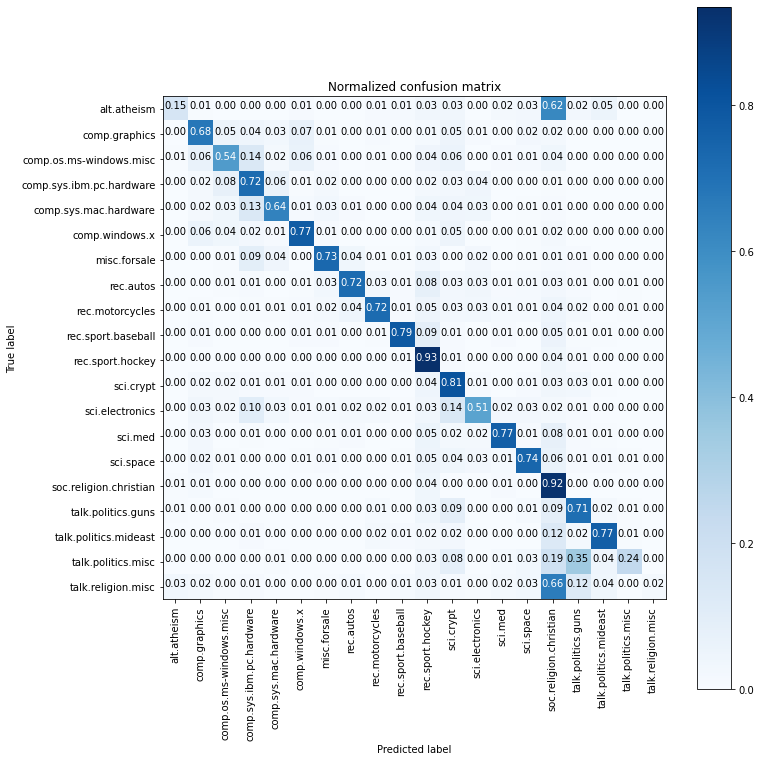

In [18]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(newsgroups_test.target, Y_predict)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(11, 11))
plot_confusion_matrix(cnf_matrix, classes=newsgroups_train.target_names, normalize=True, title='Normalized confusion matrix')

plt.show()

## Ahora vamos a usar un explainer LIME para entender que hace el clasificador

In [19]:
class_names = [x.split('.')[-1] if 'misc' not in x else '.'.join(x.split('.')[-2:]) for x in newsgroups_train.target_names]
class_names[3] = 'pc.hardware'
class_names[4] = 'mac.hardware'

In [21]:
from lime import lime_text
from sklearn.pipeline import make_pipeline

c = make_pipeline(vectorizer, clf)

In [22]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)

In [23]:
idx = 110

exp = explainer.explain_instance(test_docs[idx], c.predict_proba, num_features=5, top_labels=2)
exp.show_in_notebook(text=test_docs[idx])

Ver documentación de lime en: https://lime-ml.readthedocs.io/en/latest/index.html